In [1]:
# 1. System Setup, Warnings, Reproducibility
import warnings      # Hide warnings during training
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)



import random
import numpy as np    # Numerical operations
import pandas as pd   # Data handling (DataFrames)
from pandas import DataFrame

import torch          # Required for TabNet
import tensorflow as tf  # Used for neural network models (MLP, CNN)

# Fix randomness for reproducible results
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

import joblib  # Saving/loading scalers and models
# 2. Visualization
import matplotlib.pyplot as plt     # Basic plotting
import seaborn as sns               # Statistical visualization
import plotly.express as px         # Interactive plots
# 3. Preprocessing & Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold  # Splitting + CV
from sklearn.preprocessing import StandardScaler                        # Feature scaling
from sklearn.utils.class_weight import compute_class_weight            # Handle class imbalance
# 4. Machine Learning Models
from sklearn.linear_model import LogisticRegression         # Baseline model
from sklearn.ensemble import RandomForestClassifier         # Traditional ML benchmark
from xgboost import XGBClassifier                           # Gradient boosting model
from lightgbm import LGBMClassifier                         # Fast boosting model
from pytorch_tabnet.tab_model import TabNetClassifier       # Main model (TabNet)
# 5. Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)


In [2]:
dataset_link = r'C:\Users\ATHEER\Downloads\PRO1\Students Performance Dataset.csv'
df = pd.read_csv(dataset_link)
df

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,S5995,Ahmed,Jones,student4995@university.com,Male,19,CS,96.09,45.86,45.63,...,51.66,53.5470,F,7.8,No,No,Master's,Medium,10,4.5
4996,S5996,Emma,Brown,student4996@university.com,Male,19,Mathematics,96.30,78.67,47.42,...,52.33,59.0240,F,24.2,No,Yes,NaN,Medium,4,7.2
4997,S5997,John,Brown,student4997@university.com,Female,24,CS,89.94,50.84,65.83,...,97.89,74.7560,C,7.6,No,Yes,NaN,High,5,6.6
4998,S5998,Sara,Davis,student4998@university.com,Male,23,Engineering,99.09,55.44,57.45,...,84.74,68.6585,D,14.5,Yes,No,PhD,Medium,10,5.9


In [3]:
X = df[[
    "Attendance (%)",
    "Participation_Score",
    "Quizzes_Avg",
    "Assignments_Avg",
    "Midterm_Score",
    "Projects_Score"
]]

scaler = StandardScaler()
scaler.fit(X)

joblib.dump(scaler, "scaler.pkl")

print("✅ scaler.pkl recreated and saved!")


✅ scaler.pkl recreated and saved!


Data Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              5000 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             5000 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

In [4]:
df.describe()

,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Study_Hours_per_Week,Stress_Level (1-10),Sleep_Hours_per_Night
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,21.048400,75.356076,70.701924,69.546552,74.956320,74.836214,49.963720,74.78305,71.652097,17.521140,5.507200,6.514420
std,1.989786,14.392716,17.436325,17.108996,14.404287,14.423848,28.989785,14.54243,7.230097,7.193035,2.886662,1.446155
min,18.000000,50.010000,40.000000,40.010000,50.000000,50.000000,0.000000,50.00000,50.602000,5.000000,1.000000,4.000000
25%,19.000000,62.945000,55.707500,54.697500,62.340000,62.357500,25.075000,61.97000,66.533875,11.500000,3.000000,5.300000
50%,21.000000,75.670000,70.860000,69.485000,75.090000,74.905000,49.600000,74.54000,71.696250,17.400000,6.000000,6.500000
75%,23.000000,87.862500,85.760000,83.922500,87.352500,87.292500,75.500000,87.63000,76.711625,23.700000,8.000000,7.800000
max,24.000000,100.000000,99.990000,99.980000,99.990000,99.990000,100.000000,100.00000,95.091500,30.000000,10.000000,9.000000


In [5]:
df.isnull().sum()

Student_ID                       0
First_Name                       0
Last_Name                        0
Email                            0
Gender                           0
Age                              0
Department                       0
Attendance (%)                   0
Midterm_Score                    0
Final_Score                      0
Assignments_Avg                  0
Quizzes_Avg                      0
Participation_Score              0
Projects_Score                   0
Total_Score                      0
Grade                            0
Study_Hours_per_Week             0
Extracurricular_Activities       0
Internet_Access_at_Home          0
Parent_Education_Level        1025
Family_Income_Level              0
Stress_Level (1-10)              0
Sleep_Hours_per_Night            0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
for col in [
    "Gender", "Age", "Department","Grade",
    "Extracurricular_Activities", "Internet_Access_at_Home",
    "Parent_Education_Level", "Family_Income_Level", "Stress_Level (1-10)"]:
    print(f"Unique values for {col}:", df[col].unique())

Unique values for Gender: ['Female' 'Male']
Unique values for Age: [22 18 24 23 21 19 20]
Unique values for Department: ['Mathematics' 'Business' 'Engineering' 'CS']
Unique values for Grade: ['F' 'B' 'D' 'C' 'A']
Unique values for Extracurricular_Activities: ['Yes' 'No']
Unique values for Internet_Access_at_Home: ['No' 'Yes']
Unique values for Parent_Education_Level: ["Master's" 'High School' nan "Bachelor's" 'PhD']
Unique values for Family_Income_Level: ['Medium' 'Low' 'High']
Unique values for Stress_Level (1-10): [ 1  4  9  8  6  2  5  7 10  3]


In [8]:
df.groupby("Grade")["Total_Score"].describe()

,count,mean,std,min,25%,50%,75%,max
Grade,,,,,,,,
A,16.0,91.277375,1.373792,90.0900,90.351125,90.80425,91.748000,95.0915
B,638.0,83.127444,2.362977,80.0020,81.127125,82.64775,84.633375,89.9665
C,2307.0,74.515495,2.800034,70.0005,72.107250,74.37450,76.770750,79.9990
D,1760.0,65.795618,2.770553,60.0140,63.694500,66.16800,68.113875,69.9990
F,279.0,57.552701,2.105641,50.6020,56.411750,58.22600,59.320000,59.9925


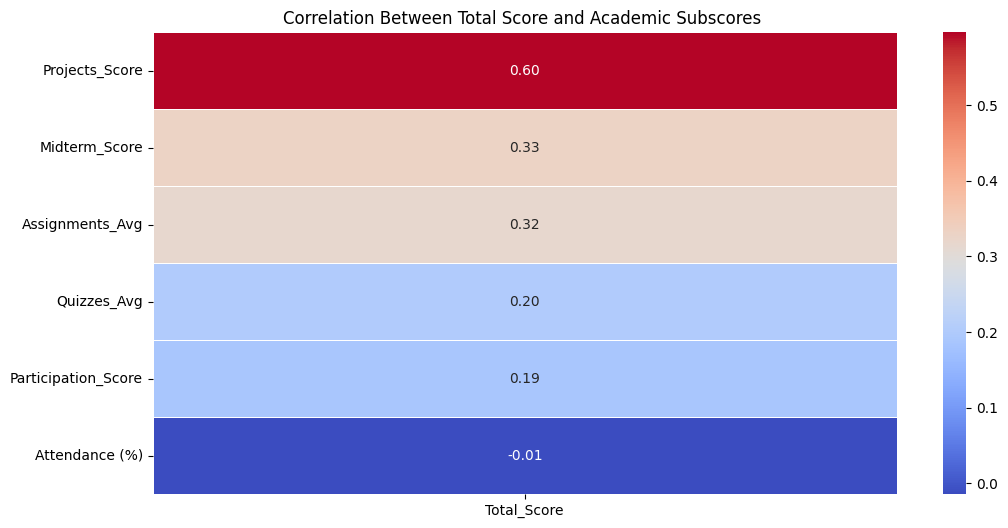

In [9]:
from typing import List
from pandas import DataFrame

def numerical_to_numerical_correlation(df: DataFrame, features: List[str], target_column: str, features_name: str = "Selected Features") -> None:
    numeric_df = df.select_dtypes(include=['number'])
    features = [feat for feat in features if feat != target_column]
    plt.figure(figsize=(12, 6))
    
    sns.heatmap(
        numeric_df.corr().loc[features, [target_column]].sort_values(by=target_column, ascending=False),
        annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
    )
    
    plt.title(f"Correlation Between {target_column} and {features_name}".replace("_", " "))
    plt.savefig(plt.gca().get_title().replace(" ", "_") + ".pdf")
    plt.show()
academic_subscores = [
    'Attendance (%)', 'Participation_Score', 'Quizzes_Avg',
    'Assignments_Avg', 'Midterm_Score',
    'Projects_Score'
]
numerical_to_numerical_correlation(df, academic_subscores, 'Total_Score',  'Academic Subscores ')

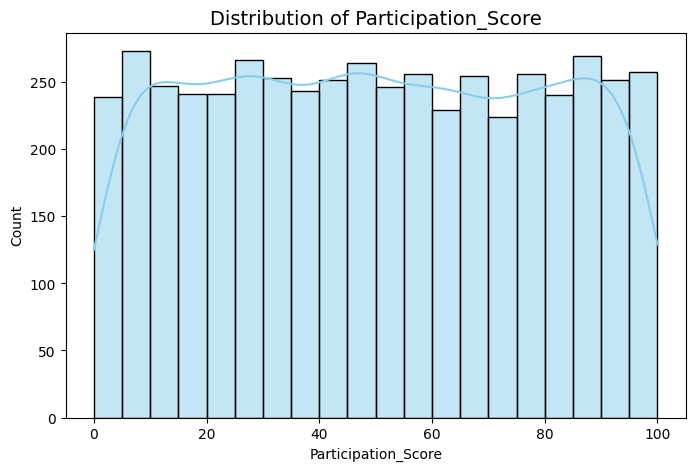

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Participation_Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Participation_Score', fontsize=14)
plt.xlabel('Participation_Score')
plt.ylabel('Count')
plt.show()

Cleaning  Data


In [11]:
#Cleaning up Data Fill missing data¶
df['Parent_Education_Level']=df['Parent_Education_Level'].fillna('Unknown')

In [12]:
#Fix Total_Score¶
# Updated score weights
score_weights = {
    "Midterm_Score": 0.15,
    "Final_Score": 0.25,
    "Assignments_Avg": 0.15,
    "Quizzes_Avg": 0.10,
    "Participation_Score": 0.05,
    "Projects_Score": 0.30,
}

df['Total_Score'] = (
    df["Midterm_Score"] * score_weights["Midterm_Score"] +
    df["Final_Score"] * score_weights["Final_Score"] +
    df["Assignments_Avg"] * score_weights["Assignments_Avg"] +
    df["Quizzes_Avg"] * score_weights["Quizzes_Avg"] +
    (df["Participation_Score"] *score_weights["Participation_Score"]) +  # scaled from [0–10] to [0–100]
    df["Projects_Score"] * score_weights["Projects_Score"]
).clip(0, 100)


In [13]:
#Finally, remove all unnecessary columns
def safe_drop(df: DataFrame, column) -> DataFrame:
    if column in df.columns:
        return df.drop(columns=column)
    return df


In [14]:
useless_columns = ['Student_ID', 'First_Name', 'Last_Name', 'Email',"Grade",'Final_Score',"Total_Score"]
for col in useless_columns:
    df = safe_drop(df, col)

    "Midterm_Score": 0.15,
    "Final_Score": 0.25,
    "Assignments_Avg": 0.15,
    "Quizzes_Avg": 0.10,
    "Participation_Score": 0.05,
    "Projects_Score": 0.30,                           
    دي المعلومه من مصدر البينات 

    يعني اعمال السنه من 75 ونصها 37.5

In [15]:
# Fix Total_Score (without Final_Score)

# Updated normalized weights after removing Final_Score
score_weights = {
    "Midterm_Score": 0.20,         # 20%
    "Assignments_Avg": 0.20,       # 20%
    "Quizzes_Avg": 0.1333,         # 13.3%
    "Participation_Score": 0.0667, # 6.7%
    "Projects_Score": 0.40         # 40%
}

# Compute new Total_Score (out of 100)
df['Total_Score'] = (
    df["Midterm_Score"] * score_weights["Midterm_Score"] +
    df["Assignments_Avg"] * score_weights["Assignments_Avg"] +
    df["Quizzes_Avg"] * score_weights["Quizzes_Avg"] +
    (df["Participation_Score"] ) * score_weights["Participation_Score"] +  # scaled 0–10 → 0–100
    df["Projects_Score"] * score_weights["Projects_Score"]
).clip(0, 100)


In [16]:
df['Total_Score'].describe()# no worst-case estimation
#min 50.553037 so that mine to not fa


count    5000.000000
mean       72.353116
std         7.793427
min        50.553037
25%        66.776997
50%        72.165994
75%        78.012722
max        95.234193
Name: Total_Score, dtype: float64

In [17]:
def classify_risk(score):

    # High Risk: <60 → Below the academic passing threshold and statistically in the lower tail of the distribution.
    if score < 60:
        return "High Risk"

    # Moderate Risk: 60–69.99 → Slightly above passing but still below the mean (≈72), indicating unstable performance.
    elif score < 70:
        return "Moderate Risk"

    # Low Risk: ≥70 → Above both the mean and median, indicating strong and stable academic performance.
    else:
        return "Low Risk"


In [18]:
df["Risk_Level"] = df["Total_Score"].apply(classify_risk)

In [19]:
df["Risk_Level"].value_counts()

Risk_Level
Low Risk         3023
Moderate Risk    1698
High Risk         279
Name: count, dtype: int64

In [20]:
df["Risk_Level"].unique()

array(['High Risk', 'Low Risk', 'Moderate Risk'], dtype=object)

In [21]:
df.columns

Index(['Gender', 'Age', 'Department', 'Attendance (%)', 'Midterm_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Study_Hours_per_Week', 'Extracurricular_Activities',
       'Internet_Access_at_Home', 'Parent_Education_Level',
       'Family_Income_Level', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night',
       'Total_Score', 'Risk_Level'],
      dtype='object')

EDA

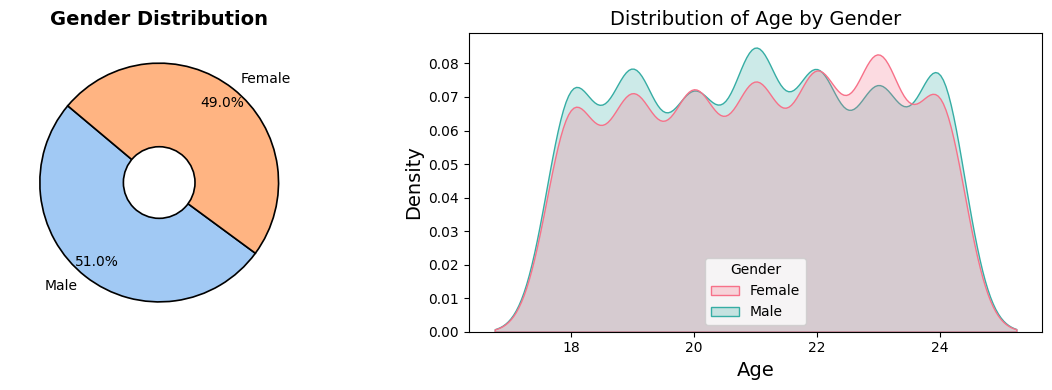

In [22]:
# Basic Data Analysis¶
#Age, Gender Distribution¶
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = sns.color_palette("pastel")
gender_counts = df['Gender'].value_counts()
wedges, texts, autotexts = axes[0].pie(
    gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
    colors=colors, startangle=140, wedgeprops={'edgecolor': 'black', 'linewidth': 1.2}, pctdistance=0.85)
center_circle = plt.Circle((0, 0), 0.3, fc='white', edgecolor='black', linewidth=1.2)
axes[0].add_artist(center_circle)
axes[0].set_title("Gender Distribution", fontsize=14, fontweight="bold")

sns.kdeplot(x='Age', data=df, hue="Gender", fill=True, palette='husl', ax=axes[1])
axes[1].set_title('Distribution of Age by Gender', fontsize=14, color='k')
axes[1].set_xlabel("Age", fontsize=14, color='k')
axes[1].set_ylabel("Density", fontsize=14, color='k')
plt.tight_layout()
plt.show()

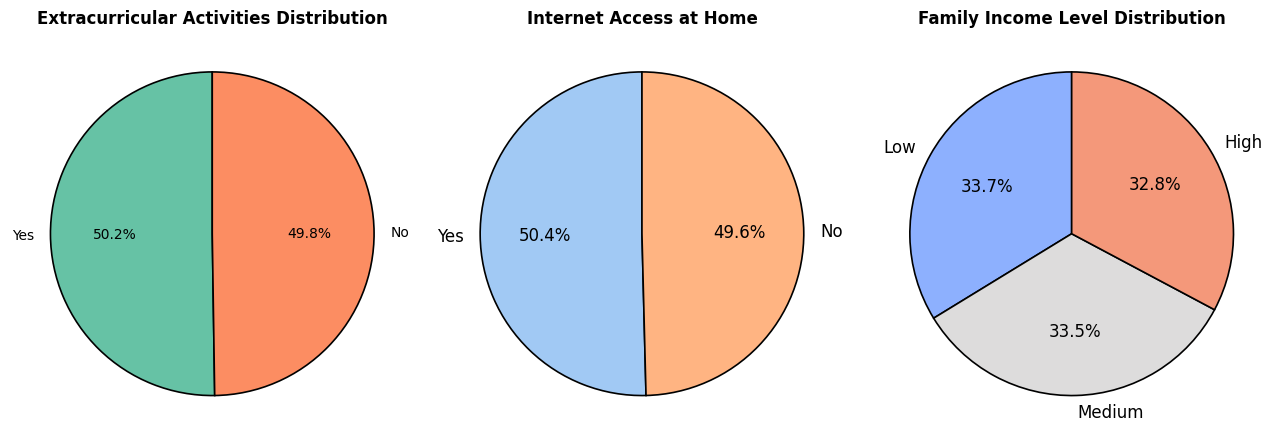

In [23]:
#Socioeconomic Factors¶
fig, axes = plt.subplots(1, 3, figsize=(13, 6))
df["Extracurricular_Activities"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", ax=axes[0], colors=sns.color_palette("Set2"),
    startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1.2}
)
axes[0].set_ylabel("")  
axes[0].set_title("Extracurricular Activities Distribution", fontsize=12, fontweight="bold")

internet_counts = df["Internet_Access_at_Home"].value_counts()
axes[1].pie(internet_counts, labels=internet_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("pastel"), startangle=90, textprops={'fontsize': 12},
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.2})
axes[1].set_title("Internet Access at Home", fontsize=12, fontweight="bold")

income_counts = df["Family_Income_Level"].value_counts()
axes[2].pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("coolwarm", len(income_counts)), startangle=90, textprops={'fontsize': 12},
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.2})
axes[2].set_title("Family Income Level Distribution", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()



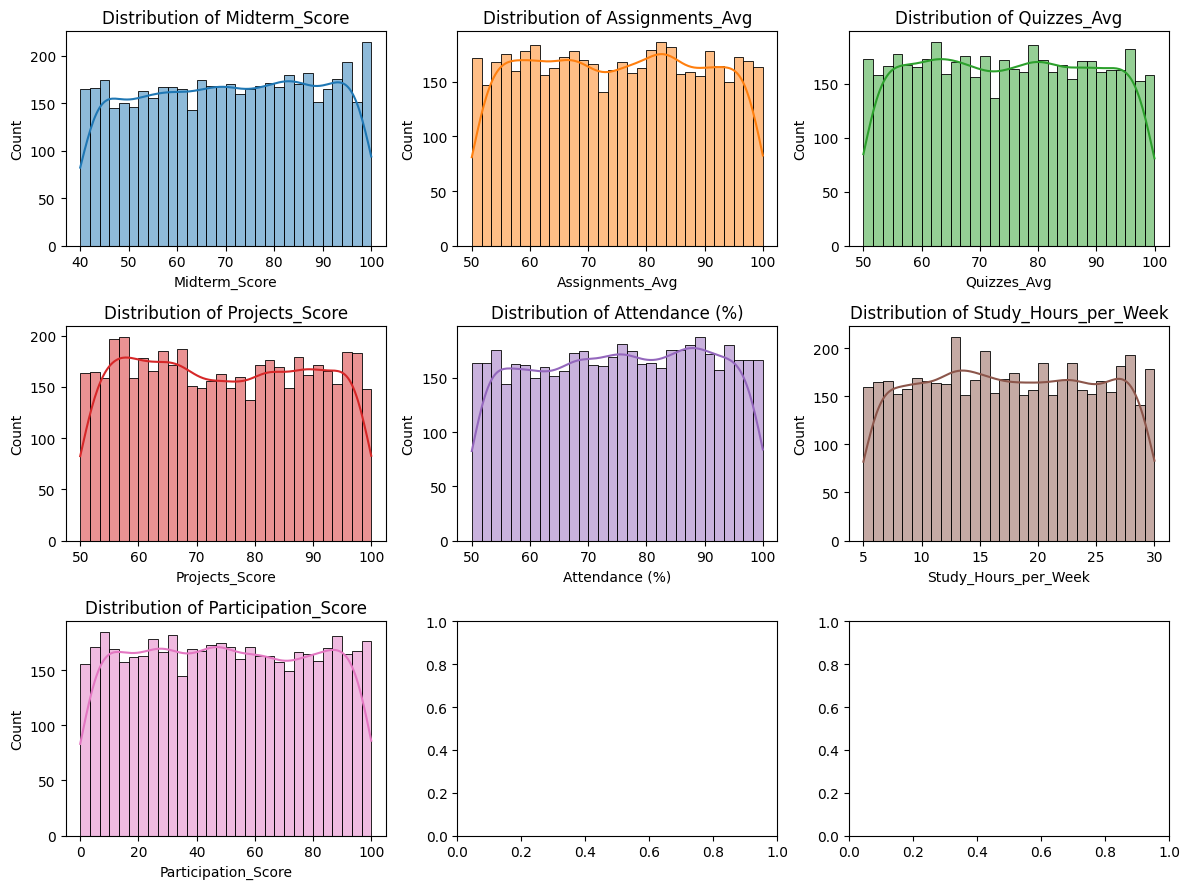

In [24]:
#Distibution of Various Academic Metrics¶
cols = ["Midterm_Score", "Assignments_Avg", "Quizzes_Avg", "Projects_Score",
         "Attendance (%)", "Study_Hours_per_Week", "Participation_Score"]
ncols = 3
nrows = int(np.ceil(len(cols) / ncols))

colors = sns.color_palette("tab10", len(cols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 3))
axes = axes.flatten()

for ax, col, color in zip(axes, cols, colors):
    sns.histplot(df[col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


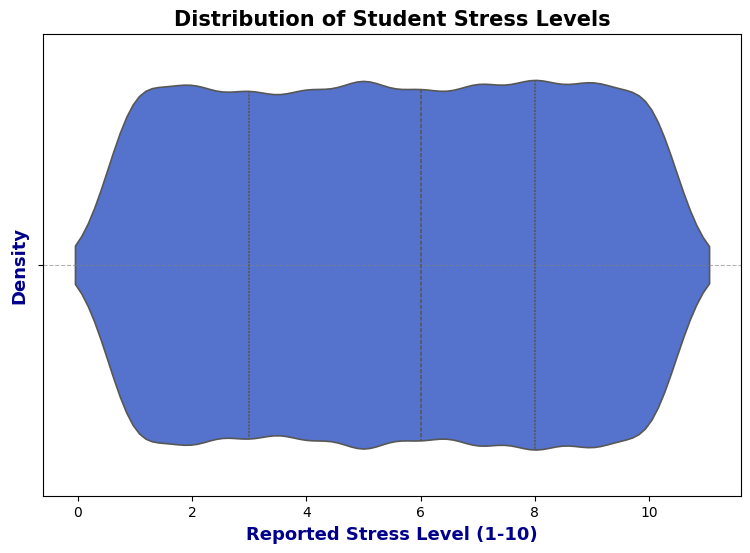

In [25]:
#Stress Levels¶
plt.figure(figsize=(9, 6))
sns.violinplot(x=df["Stress_Level (1-10)"], color="royalblue", inner="quartile", linewidth=1.2)

plt.xlabel("Reported Stress Level (1-10)", fontsize=13, fontweight="bold", color="darkblue")
plt.ylabel("Density", fontsize=13, fontweight="bold", color="darkblue")
plt.title("Distribution of Student Stress Levels", fontsize=15, fontweight="bold", color="black")
plt.grid(axis='y', linestyle="--", alpha=0.6, color="gray")

plt.show()

In [26]:
#High-level Correlations in current Data¶
def plot_numerical_correlation(df: DataFrame, title: str = "Correlation Heatmap of Continous Data", x: List[str] = None, only_total_score: bool = False):
    numeric_df = df.select_dtypes(include=['number'])
    if only_total_score:
        keep_cols = [col for col in numeric_df.columns if col not in academic_subscores]
        corr_data = numeric_df[keep_cols].corr()
        plt.figure(figsize=(10, len(keep_cols) * 0.5 + 2))
    else:
        corr_data = numeric_df.corr()
        plt.figure(figsize=(10, 6))

    sns.heatmap(corr_data, annot=True, cmap="RdBu_r", fmt=".2f", linewidths=1)
    plt.title(title)
    # plt.savefig(title.replace(" ", "_") + ".pdf")
    plt.show()

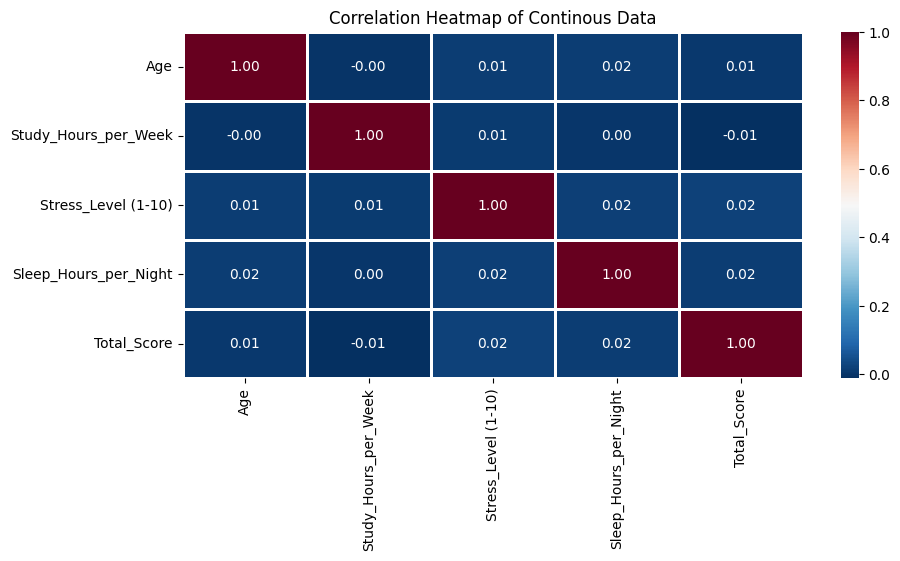

In [27]:
plot_numerical_correlation(df, only_total_score=True)

In [28]:
import math

def regression_to_total_score(df: DataFrame, x_columns: List[str], figsize=(17, 4)):
    n = len(x_columns)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, x_col in enumerate(x_columns):
        sns.regplot(
            x=df[x_col], y=df["Total_Score"],
            scatter_kws={"s": 10}, line_kws={"color": "red"},
            ax=axes[i]
        )
        axes[i].set_title(f"Regression of Total Score vs {x_col.replace('_', ' ')}",
                          fontsize=14, fontweight="bold", color="darkred")
        axes[i].set_xlabel(x_col.replace("_", " "), fontsize=12)
        axes[i].set_ylabel("Total Score", fontsize=12)
        axes[i].grid(True, linestyle="--", alpha=0.6)
    
    # Hide unused axes
    for j in range(len(x_columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


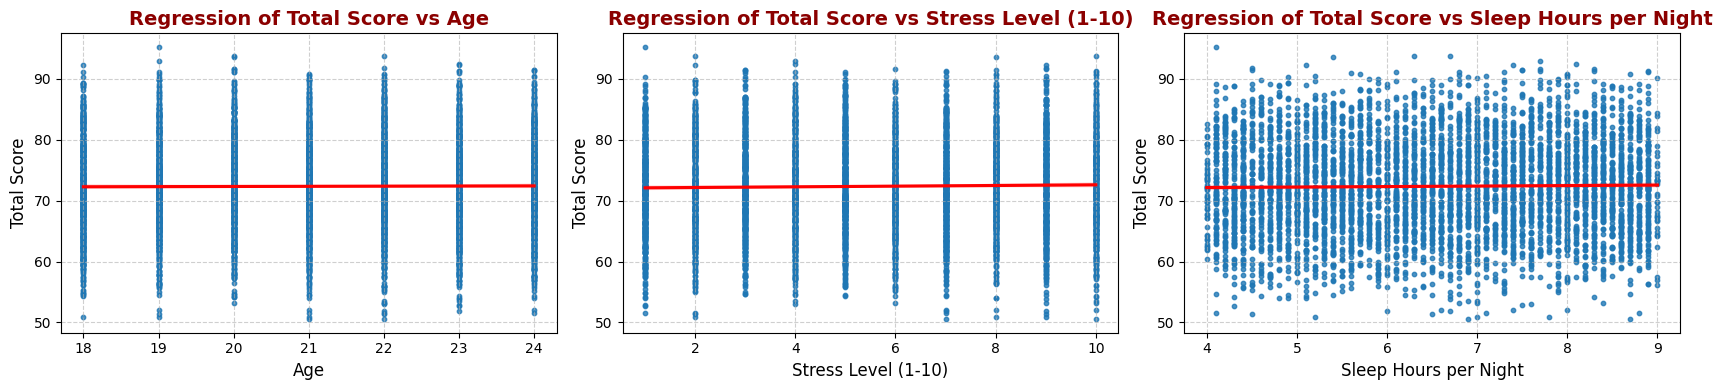

In [29]:
_cols = [col for col in df.select_dtypes(include=['number']).columns if col != 'Total_Score' and col != 'Study_Hours_per_Week' and col not in academic_subscores]
regression_to_total_score(df, _cols)


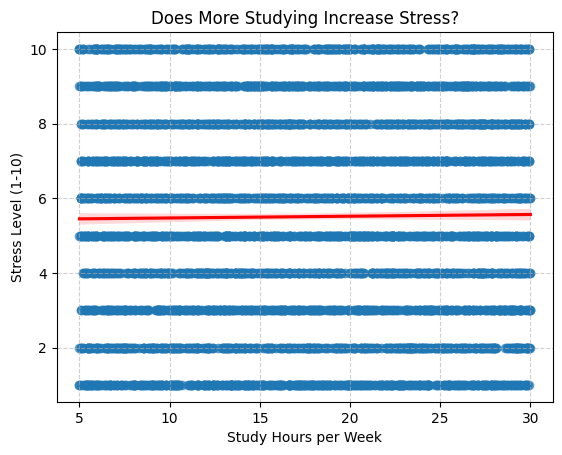

In [30]:
sns.regplot(x=df["Study_Hours_per_Week"], y=df["Stress_Level (1-10)"], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title("Does More Studying Increase Stress?")
plt.xlabel("Study Hours per Week")
plt.ylabel("Stress Level (1-10)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


feature engineer

In [31]:
# How consistent is the student across subscores (higher = more consistant performance across the field)
df["Consistency_Score"] = df[academic_subscores].std(axis=1)

In [32]:
academic_subscores

['Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score']

In [33]:
# (sleep+play)-study balance = sleep hours & whether a student participates in outside activities, divided by study hours
#                                              (higher = prioritizing sleep and extracurricular activities)
# This is similar to the notion of "work-life balance"
df["Sleep_Play_Study_Balance"] = df.apply(
    lambda row: (row["Sleep_Hours_per_Night"] + (2 if row["Extracurricular_Activities"] == "Yes" else 0)) / (row["Study_Hours_per_Week"] / 7),
    axis=1
)

In [34]:
# How enjoyable is the student's life while studying (higher = happier)
income_bonus = {
    'Low': 0,
    'Medium': 5,
    'High': 10,
}
df["Happiness_Score"] = df.apply(
    lambda row:
        row["Participation_Score"] +  # engaged with the content of the class
        (1 - row["Study_Hours_per_Week"] / 168) * 1000 +  # doesn't spend much time studying outside of class
        (10 if row["Extracurricular_Activities"] == "Yes" else 0) +  # participates in extracurricular activities
        (10 if row["Internet_Access_at_Home"] == "Yes" else 0) +  # has internet at home
        income_bonus.get(row["Family_Income_Level"], 0) +  # parents are rich
        (10 - row["Stress_Level (1-10)"]) +  # is not stressed
        row["Sleep_Hours_per_Night"],  # gets to sleep a lot
    axis=1
)


In [35]:
#df["Academic_Efficiency"] = df["Total_Score"] / (df["Study_Hours_per_Week"] + 1)
df["Engagement_Index"] = (
    df["Attendance (%)"] * 0.5 +
    df["Participation_Score"] * 0.3 +
    (df["Extracurricular_Activities"].map({"Yes": 1, "No": 0}) * 20)
    
)
#df["Stress_Performance_Ratio"] = df["Stress_Level (1-10)"] / (df["Total_Score"] + 1)

df["Consistency_Index"] = 1 / (1 + df[academic_subscores].std(axis=1))
df["Wellness_Index"] = (
    (df["Sleep_Hours_per_Night"] * 10) +
    (10 - df["Stress_Level (1-10)"]) * 5 +
    (df["Extracurricular_Activities"].map({"Yes": 1, "No": 0}) * 10)
)

In [36]:
new_features = [
    "Consistency_Score",
    "Sleep_Play_Study_Balance",
    "Happiness_Score",
    "Consistency_Index",
    #"Academic_Efficiency",
    "Engagement_Index",
    #"Stress_Performance_Ratio",
    "Wellness_Index"
]

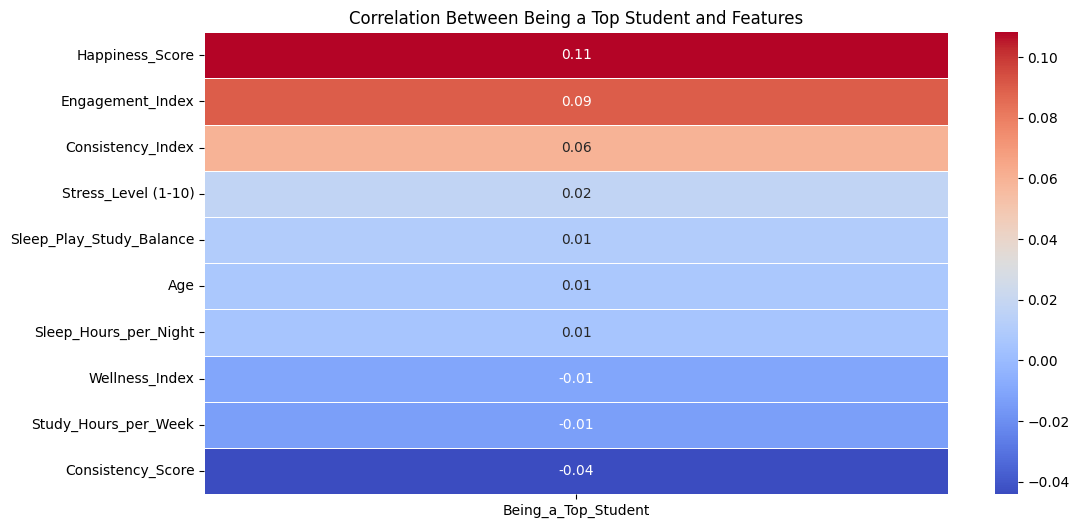

In [37]:
#Analysis under new lens
# We flag students whose grade is B+ or above as the "Top students"
#        B+ students have Total_Score >= 80 (from the official link, cited above, section 1.2.2)
df["Being_a_Top_Student"] = (df["Total_Score"] >=70)
_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in academic_subscores and col != 'Total_Score']
df["Being_a_Top_Student"] = df["Being_a_Top_Student"].astype(int)
numerical_to_numerical_correlation(df, _cols, 'Being_a_Top_Student', 'Features')


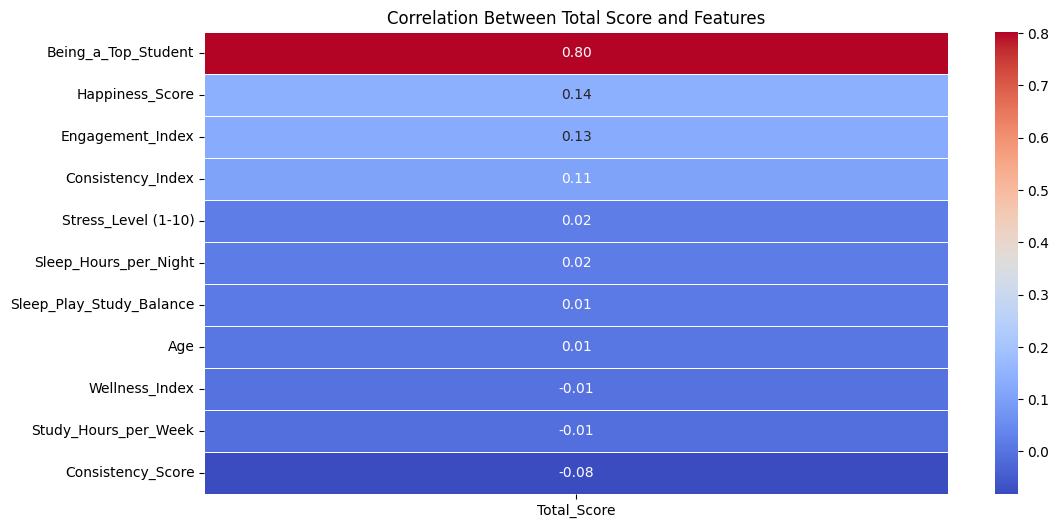

In [38]:
#Analysis under new lens
# We flag students whose grade is B+ or above as the "Top students"
#        B+ students have Total_Score >= 80 (from the official link, cited above, section 1.2.2)
_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in academic_subscores and col != 'Total_Score']
numerical_to_numerical_correlation(df, _cols, 'Total_Score', 'Features')

In [39]:
useless_columns = ['Being_a_Top_Student','Total_Score']
for col in useless_columns:
    df = safe_drop(df, col)

creat copy to make sure that data are saved

In [40]:
df2=df.copy()

In [41]:
df2=df.copy()
useless_columns = ["Gender", "Age", "Department","Grade",
    "Extracurricular_Activities", "Internet_Access_at_Home",
    "Parent_Education_Level", "Family_Income_Level", "Stress_Level (1-10)",
    "Consistency_Score",
    "Sleep_Play_Study_Balance",
    "Happiness_Score",
    "Consistency_Index",
    "Sleep_Hours_per_Night",
    "Engagement_Index",
    "Study_Hours_per_Week",
    "Wellness_Index","Risk_Level"]

for col in useless_columns:
    df2= safe_drop(df2, col)


In [42]:
df3=df2.copy()

In [43]:
df1=df.copy()

In [44]:
useless_columns = ["Gender", "Age", "Department","Grade",
    
    "Consistency_Index",
'Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score',"Risk_Level"]
for col in useless_columns:
    df1 = safe_drop(df1, col)


Baseline Model

In [ ]:
# Define features (X) and label (y)
X = df[[ 'Attendance (%)',
 'Participation_Score',
 'Quizzes_Avg',
 'Assignments_Avg',
 'Midterm_Score',
 'Projects_Score']]
y = df['Risk_Level']



Baseline Model with Cross-validation

In [ ]:
from sklearn.preprocessing import LabelEncoder
#  Create encoder
encoder = LabelEncoder()
# Fit and transform labels
y = encoder.fit_transform(y)
# Extract mapping
label_map = {label: idx for idx, label in enumerate(encoder.classes_)}
print("Label Mapping:", label_map)


Label Mapping: {'High Risk': 0, 'Low Risk': 1, 'Moderate Risk': 2}


In [ ]:
# Prepare data
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
X_np = X.values if hasattr(X, "values") else X
y_np = y.values if hasattr(y, "values") else y
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#  Helper metrics

def evaluate_model(name, preds, y_true):
    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, average='macro')
    rec = recall_score(y_true, preds, average='macro')
    f1_macro = f1_score(y_true, preds, average='macro')
    f1_weighted = f1_score(y_true, preds, average='weighted')
    bacc = balanced_accuracy_score(y_true, preds)

    print(f"{name:10} | Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | F1_macro={f1_macro:.3f} | F1_weighted={f1_weighted:.3f} | BAcc={bacc:.3f}")

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "BalancedAcc": bacc
    }


In [ ]:
# Cross-validation loop
results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    # === XGBoost ===
    xgb = XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        random_state=42, n_estimators=200
    )
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    results.append(evaluate_model("XGBoost", preds, y_test))

    # === LightGBM ===
    lgb = LGBMClassifier(is_unbalance=True, random_state=42)
    lgb.fit(X_train, y_train)
    preds = lgb.predict(X_test)
    results.append(evaluate_model("LightGBM", preds, y_test))

    # === MLP (Keras) ===
    tf.keras.backend.clear_session()
    mlp = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    mlp.fit(X_train, y_train_cat, epochs=10, batch_size=16, verbose=0)
    preds = np.argmax(mlp.predict(X_test), axis=1)
    results.append(evaluate_model("MLP", preds, y_test))

    # === TabNet (PyTorch) ===
    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32,
        
    )
    preds = tabnet.predict(X_test)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.944 | Prec=0.945 | Rec=0.891 | F1_macro=0.915 | F1_weighted=0.943 | BAcc=0.891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score -2.886878
[LightGBM] [Info] Start training from score -0.503354
[LightGBM] [Info] Start training from score -1.079545
LightGBM   | Acc=0.938 | Prec=0.932 | Rec=0.888 | F1_macro=0.908 | F1_weighted=0.938 | BAcc=0.888

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP        | Acc=0.716 | Prec=0.665 | Rec=0.528 | F1_macro=0.547 | F1_weighted=0.705 | BAcc=0.528
epoch 0  | loss: 0.4821  | val_0_accuracy: 0.605   |  0:00:03s
epoch 1  | loss: 0.30335 | val_0_accuracy: 0.78    |  0:00:06s
epoch 2  | loss: 0.25363 | val_0_accuracy: 0.895   |  0:00:09s
epoch 3

In [ ]:
# Aggregate and summarize results
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"])
print("\n=== Cross-Validation Generalization Results ===")
print(summary.round(4))



=== Cross-Validation Generalization Results ===
         Accuracy         Precision          Recall         F1_macro          \
             mean     std      mean     std    mean     std     mean     std   
Model                                                                          
LightGBM   0.9400  0.0051    0.9278  0.0122  0.8784  0.0084   0.8999  0.0092   
MLP        0.7246  0.0247    0.6924  0.0792  0.5152  0.0386   0.5295  0.0473   
TabNet     0.9548  0.0093    0.9520  0.0127  0.9074  0.0221   0.9268  0.0137   
XGBoost    0.9450  0.0019    0.9412  0.0090  0.8849  0.0099   0.9092  0.0072   

         F1_weighted         BalancedAcc          
                mean     std        mean     std  
Model                                             
LightGBM      0.9394  0.0052      0.8784  0.0084  
MLP           0.7043  0.0319      0.5152  0.0386  
TabNet        0.9545  0.0095      0.9074  0.0221  
XGBoost       0.9444  0.0018      0.8849  0.0099  


In [ ]:
print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["F1_weighted"]["mean"].idxmax()
best_score = summary.loc[best_model, ("F1_weighted", "mean")]
print(f" Best model: {best_model} (F1_weighted={best_score:.3f})")



==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (F1_weighted=0.954)


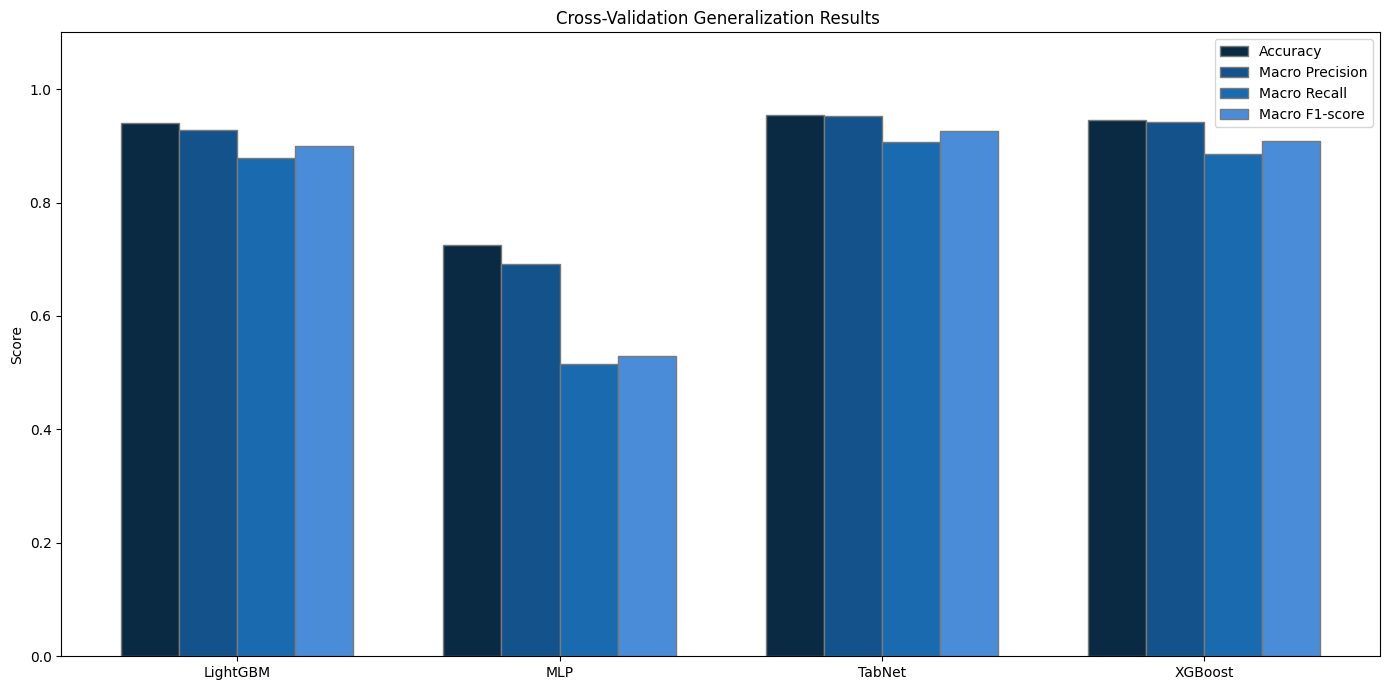

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ["LightGBM", "MLP", "TabNet", "XGBoost"]

# Macro-average metrics (mean) from CV results
accuracy =   [0.9400, 0.7246, 0.9548, 0.9450]
precision =  [0.9278, 0.6924, 0.9520, 0.9412]
recall =     [0.8784, 0.5152, 0.9074, 0.8849]
f1_macro =   [0.8999, 0.5295, 0.9268, 0.9092]

x = np.arange(len(models))
width = 0.18

# Blue shades (dark → light)
blue_shades = ["#0a2a43", "#13528a", "#1a6ab0", "#4a8cd8"]
gray = "#7a7a7a"

plt.figure(figsize=(14, 7))

plt.bar(x - 1.5*width, accuracy, width, label="Accuracy", color=blue_shades[0], edgecolor=gray)
plt.bar(x - 0.5*width, precision, width, label="Macro Precision", color=blue_shades[1], edgecolor=gray)
plt.bar(x + 0.5*width, recall, width, label="Macro Recall", color=blue_shades[2], edgecolor=gray)
plt.bar(x + 1.5*width, f1_macro, width, label="Macro F1-score", color=blue_shades[3], edgecolor=gray)

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Cross-Validation Generalization Results ")

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Cross-validation loop
results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    # === XGBoost ===
    xgb = XGBClassifier(
        use_label_encoder=False, eval_metric='logloss',
        random_state=42, n_estimators=200
    )
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    results.append(evaluate_model("XGBoost", preds, y_test))

    # === LightGBM ===
    lgb = LGBMClassifier(is_unbalance=True, random_state=42)
    lgb.fit(X_train, y_train)
    preds = lgb.predict(X_test)
    results.append(evaluate_model("LightGBM", preds, y_test))

    # === MLP (Keras) ===
    tf.keras.backend.clear_session()
    mlp = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    mlp.fit(X_train, y_train_cat, epochs=10, batch_size=16, verbose=0)
    preds = np.argmax(mlp.predict(X_test), axis=1)
    results.append(evaluate_model("MLP", preds, y_test))

    # === TabNet (PyTorch) ===
    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32,
        
    )
    preds = tabnet.predict(X_test)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.944 | BAcc=0.891 | MacroF1=0.915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] Start training from score -2.886878
[LightGBM] [Info] Start training from score -0.503354
[LightGBM] [Info] Start training from score -1.079545
LightGBM   | Acc=0.938 | BAcc=0.888 | MacroF1=0.908

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP        | Acc=0.750 | BAcc=0.562 | MacroF1=0.590
epoch 0  | loss: 0.4821  | val_0_accuracy: 0.605   |  0:00:05s
epoch 1  | loss: 0.30335 | val_0_accuracy: 0.78    |  0:00:10s
epoch 2  | loss: 0.25363 | val_0_accuracy: 0.895   |  0:00:14s
epoch 3  | loss: 0.23022 | val_0_accuracy: 0.892   |  0:00:18s
epoch 4  | loss: 0.23521 | val_0_accuracy: 0.929   |  0:00:22s
epoch 5  | loss: 0.2

In [ ]:
# Aggregate and summarize results
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"])
print("\n=== Cross-Validation Generalization Results ===")
print(summary.round(4))


=== Cross-Validation Generalization Results ===
             Acc            BAcc         MacroF1        
            mean     std    mean     std    mean     std
Model                                                   
LightGBM  0.9400  0.0051  0.8784  0.0084  0.8999  0.0092
MLP       0.7430  0.0145  0.5374  0.0226  0.5626  0.0324
TabNet    0.9548  0.0093  0.9074  0.0221  0.9268  0.0137
XGBoost   0.9450  0.0019  0.8849  0.0099  0.9092  0.0072


In [ ]:

print("\n==================== Cross-Validation Summary ====================")
for model, row in summary.iterrows():
    acc_mean, acc_std = row[("Acc", "mean")], row[("Acc", "std")]
    bacc_mean, bacc_std = row[("BAcc", "mean")], row[("BAcc", "std")]
    f1_mean, f1_std = row[("MacroF1", "mean")], row[("MacroF1", "std")]

    print(f"{model:10s} | "
          f"Acc={acc_mean:.3f}±{acc_std:.3f} | "
          f"BAcc={bacc_mean:.3f}±{bacc_std:.3f} | "
          f"MacroF1={f1_mean:.3f}±{f1_std:.3f}")

print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["MacroF1"]["mean"].idxmax()
best_score = summary.loc[best_model, ("MacroF1", "mean")]
print(f" Best model: {best_model} (MacroF1={best_score:.3f})")



==================== Cross-Validation Summary ====================
LightGBM   | Acc=0.940±0.005 | BAcc=0.878±0.008 | MacroF1=0.900±0.009
MLP        | Acc=0.743±0.015 | BAcc=0.537±0.023 | MacroF1=0.563±0.032
TabNet     | Acc=0.955±0.009 | BAcc=0.907±0.022 | MacroF1=0.927±0.014
XGBoost    | Acc=0.945±0.002 | BAcc=0.885±0.010 | MacroF1=0.909±0.007

==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (MacroF1=0.927)


Baseline Model with Cross-validation and SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    #SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled  = scaler.transform(X_test)

    y_train_cat = to_categorical(y_train_res, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                        random_state=42, n_estimators=200)
    xgb.fit(X_train_scaled, y_train_res)
    preds = xgb.predict(X_test_scaled)
    results.append(evaluate_model("XGBoost", preds, y_test))

    lgb = LGBMClassifier(is_unbalance=False, random_state=42)
    lgb.fit(X_train_scaled, y_train_res)
    preds = lgb.predict(X_test_scaled)
    results.append(evaluate_model("LightGBM", preds, y_test))

    tf.keras.backend.clear_session()
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
    class_weights = dict(enumerate(class_weights))

    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train_scaled, y_train_res,
        eval_set=[(X_test_scaled, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32
    )
    preds = tabnet.predict(X_test_scaled)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.951 | Prec=0.931 | Rec=0.929 | F1_macro=0.930 | F1_weighted=0.951 | BAcc=0.929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7254, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM   | Acc=0.947 | Prec=0.915 | Rec=0.938 | F1_macro=0.926 | F1_weighted=0.947 | BAcc=0.938
epoch 0  | loss: 0.43622 | val_0_accuracy: 0.902   |  0:00:04s
epoch 1  | loss: 0.26506 | val_0_accuracy: 0.898   |  0:00:12s
epoch 2  | loss: 0.24271 | val_0_accuracy: 0.916   |  0:00:20s
epoch 3  | loss: 0.25376 | val_0_accuracy: 0.915   |  0:00:28s
epoch 4  | loss: 0.2194  | val_0_accuracy: 0.891   |  0:00:37s
epoch 5  | loss: 0.2

In [ ]:
# Aggregate and summarize results
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"])
print("\n=== Cross-Validation Generalization Results with SMOTE ===")
print(summary.round(4))


=== Cross-Validation Generalization Results with SMOTE ===
         Accuracy         Precision          Recall         F1_macro          \
             mean     std      mean     std    mean     std     mean     std   
Model                                                                          
LightGBM   0.9414  0.0060    0.9111  0.0112  0.9116  0.0183   0.9111  0.0136   
TabNet     0.9570  0.0069    0.9218  0.0133  0.9582  0.0065   0.9382  0.0075   
XGBoost    0.9486  0.0035    0.9240  0.0047  0.9209  0.0157   0.9222  0.0092   

         F1_weighted         BalancedAcc          
                mean     std        mean     std  
Model                                             
LightGBM      0.9416  0.0060      0.9116  0.0183  
TabNet        0.9574  0.0070      0.9582  0.0065  
XGBoost       0.9486  0.0035      0.9209  0.0157  


In [ ]:
print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["F1_weighted"]["mean"].idxmax()
best_score = summary.loc[best_model, ("F1_weighted", "mean")]
print(f" Best model: {best_model} (F1_weighted={best_score:.3f})")



==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (F1_weighted=0.957)


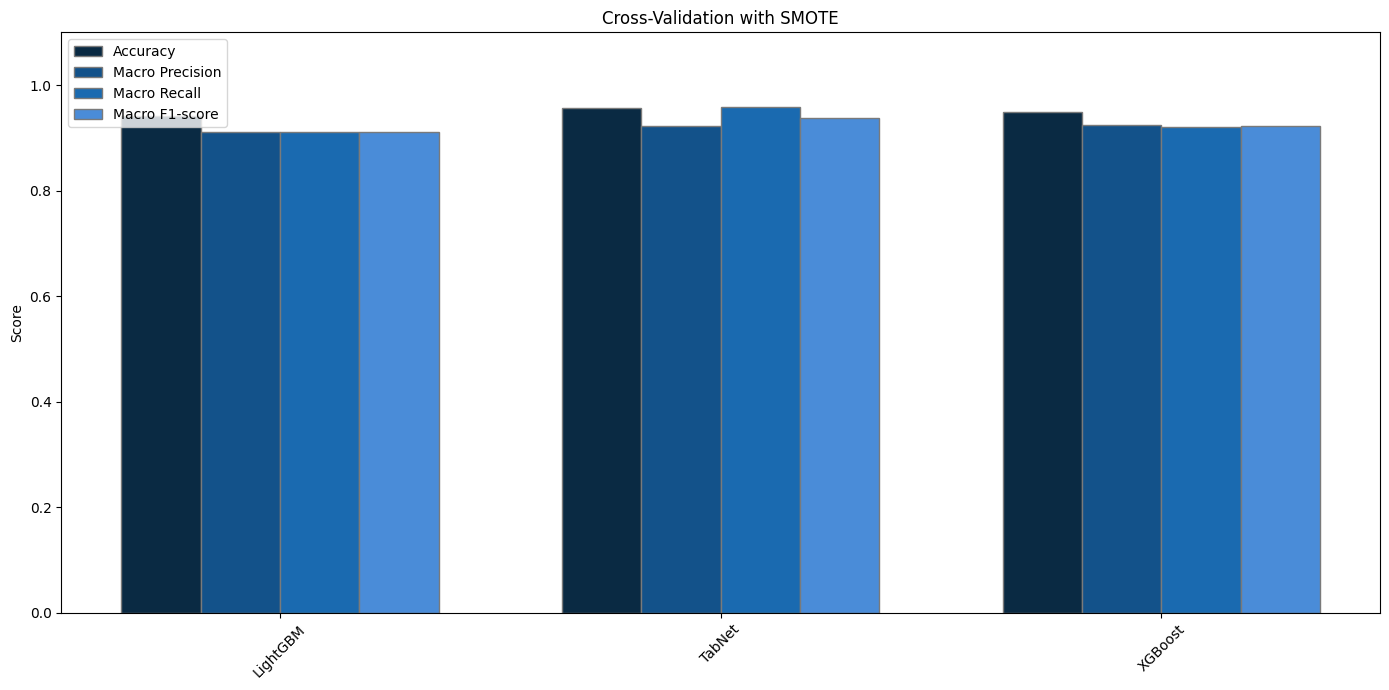

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ["LightGBM", "TabNet", "XGBoost"]

# Macro-average metrics from SMOTE CV results
accuracy = [0.9414, 0.9570, 0.9486]
precision = [0.9111, 0.9218, 0.9240]     # Macro precision
recall = [0.9116, 0.9582, 0.9209]        # Macro recall
f1 = [0.9111, 0.9382, 0.9222]            # Macro F1-score

x = np.arange(len(models))
width = 0.18

# Blue theme (dark → light) + gray outlines
blue_shades = ["#0a2a43", "#13528a", "#1a6ab0", "#4a8cd8"]
gray = "#7a7a7a"

plt.figure(figsize=(14, 7))

plt.bar(x - 1.5*width, accuracy, width, label="Accuracy", color=blue_shades[0], edgecolor=gray)
plt.bar(x - 0.5*width, precision, width, label="Macro Precision", color=blue_shades[1], edgecolor=gray)
plt.bar(x + 0.5*width, recall, width, label="Macro Recall", color=blue_shades[2], edgecolor=gray)
plt.bar(x + 1.5*width, f1, width, label="Macro F1-score", color=blue_shades[3], edgecolor=gray)

plt.xticks(x, models, rotation=45)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Cross-Validation with SMOTE")

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
results = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X_np, y_np), 1):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X_np[train_idx], X_np[test_idx]
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    #SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled  = scaler.transform(X_test)

    y_train_cat = to_categorical(y_train_res, num_classes)
    y_test_cat  = to_categorical(y_test, num_classes)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                        random_state=42, n_estimators=200)
    xgb.fit(X_train_scaled, y_train_res)
    preds = xgb.predict(X_test_scaled)
    results.append(evaluate_model("XGBoost", preds, y_test))

    lgb = LGBMClassifier(is_unbalance=False, random_state=42)
    lgb.fit(X_train_scaled, y_train_res)
    preds = lgb.predict(X_test_scaled)
    results.append(evaluate_model("LightGBM", preds, y_test))

    tf.keras.backend.clear_session()
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
    class_weights = dict(enumerate(class_weights))

    tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam)
    tabnet.fit(
        X_train_scaled, y_train_res,
        eval_set=[(X_test_scaled, y_test)],
        eval_metric=['accuracy'],
        max_epochs=20, patience=5, batch_size=32
    )
    preds = tabnet.predict(X_test_scaled)
    results.append(evaluate_model("TabNet", preds, y_test))


===== Fold 1 =====
XGBoost    | Acc=0.951 | BAcc=0.929 | MacroF1=0.930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7254, number of used features: 6
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM   | Acc=0.947 | BAcc=0.938 | MacroF1=0.926
epoch 0  | loss: 0.43622 | val_0_accuracy: 0.902   |  0:00:09s
epoch 1  | loss: 0.26506 | val_0_accuracy: 0.898   |  0:00:18s
epoch 2  | loss: 0.24271 | val_0_accuracy: 0.916   |  0:00:27s
epoch 3  | loss: 0.25376 | val_0_accuracy: 0.915   |  0:00:36s
epoch 4  | loss: 0.2194  | val_0_accuracy: 0.891   |  0:00:45s
epoch 5  | loss: 0.20185 | val_0_accuracy: 0.905   |  0:00:54s
epoch 6  | loss: 0.19275 | val_0_accuracy: 0.931 

In [ ]:
df_results = pd.DataFrame(results)
summary = df_results.groupby("Model").agg(["mean", "std"]).round(4)
print("\n=== Cross-Validation Generalization Results with SMOTE ===")
print(summary)
print("\n Best model:", summary['MacroF1']['mean'].idxmax())


=== Cross-Validation Generalization Results with SMOTE ===
             Acc            BAcc         MacroF1        
            mean     std    mean     std    mean     std
Model                                                   
LightGBM  0.9414  0.0060  0.9116  0.0183  0.9111  0.0136
TabNet    0.9570  0.0069  0.9582  0.0065  0.9382  0.0075
XGBoost   0.9486  0.0035  0.9209  0.0157  0.9222  0.0092

 Best model: TabNet


In [ ]:
print("\n==================== Cross-Validation Summary ====================")
for model, row in summary.iterrows():
    acc_mean, acc_std = row[("Acc", "mean")], row[("Acc", "std")]
    bacc_mean, bacc_std = row[("BAcc", "mean")], row[("BAcc", "std")]
    f1_mean, f1_std = row[("MacroF1", "mean")], row[("MacroF1", "std")]

    print(f"{model:10s} | "
          f"Acc={acc_mean:.3f}±{acc_std:.3f} | "
          f"BAcc={bacc_mean:.3f}±{bacc_std:.3f} | "
          f"MacroF1={f1_mean:.3f}±{f1_std:.3f}")

print("\n==================== Best Model (by MacroF1 mean) ====================")
best_model = summary["MacroF1"]["mean"].idxmax()
best_score = summary.loc[best_model, ("MacroF1", "mean")]
print(f" Best model: {best_model} (MacroF1={best_score:.3f})")



==================== Cross-Validation Summary ====================
LightGBM   | Acc=0.941±0.006 | BAcc=0.912±0.018 | MacroF1=0.911±0.014
TabNet     | Acc=0.957±0.007 | BAcc=0.958±0.006 | MacroF1=0.938±0.007
XGBoost    | Acc=0.949±0.004 | BAcc=0.921±0.016 | MacroF1=0.922±0.009

==================== Best Model (by MacroF1 mean) ====================
 Best model: TabNet (MacroF1=0.938)


Proposed Algorithm 

In [ ]:
# ---- Select features and target ----
feature_cols = [
    'Attendance (%)',
    'Participation_Score',
    'Quizzes_Avg',
    'Assignments_Avg',
    'Midterm_Score',
    'Projects_Score'
]
target_col = 'Risk_Level'

X = df[feature_cols].values
y = df[target_col].values   # assuming already encoded as 0,1,2


# 3. Train / Val / Test Spli t 
# 70% train, 15% val, 15% test (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Val size  :", X_val.shape[0])
print("Test size :", X_test.shape[0])

# 4. Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 5. Class Weights (soft-balanced)
#Because the dataset is imbalanced (High-Risk students are rare)
#the model may naturally favor majority classes.
classes = np.unique(y_train)
raw_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

# Soften extreme imbalance a bit to keep high accuracy:
#  - raw_weights could be like [5.98, 0.55, 0.98]
#  - we raise them to power 0.8 to reduce extremes
soft_weights = raw_weights ** 0.8

class_weights = dict(zip(classes, soft_weights))
print("\nRaw class weights: ", dict(zip(classes, raw_weights)))
print("Soft class weights:", class_weights)


Train size: 3500
Val size  : 750
Test size : 750

Raw class weights:  {'High Risk': 5.982905982905983, 'Low Risk': 0.5513547574039067, 'Moderate Risk': 0.9812167087188113}
Soft class weights: {'High Risk': 4.183403376669639, 'Low Risk': 0.6210762198292828, 'Moderate Risk': 0.9849449277319932}


In [ ]:
# ============================================================
# 1. TabNet Model with Class Weights (Proposed Algorithm)
# ============================================================
# This model represents the proposed deep-learning approach.
# It uses TabNet, a sequential attention-based architecture 
# specifically designed for tabular data. 
#
# Several training strategies are included:
#   • Feature normalization (from preprocessing stage)
#   • Soft-balanced class weights to handle class imbalance 
#   • Cosine learning rate scheduler for stable convergence
#   • Sparsemax masks to enhance feature interpretability
#   • Early stopping to prevent overfitting
#
# These design choices improve generalization, stability, 
# and performance—especially for the minority (High-Risk) class.

tabnet = TabNetClassifier(
    n_d=24,                   # Dimension of decision prediction layer
    n_a=24,                   # Dimension of attention layer
    n_steps=4,                # Number of sequential attention steps
    gamma=1.3,                # Relaxation factor for attention sparsity
    lambda_sparse=1e-5,       # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={
        "T_max": 50,          # Max iterations before LR restart
        "eta_min": 1e-5       # Minimum learning rate
    },
    mask_type='sparsemax',    # Sparse attention improves interpretability
    seed=42,
    verbose=1
)

# 2. Train the Proposed Algorithm
print("\n=== PROPOSED ALGORITHM - TABNET WITH CLASS WEIGHTS ===")

tabnet.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,                   # Stops early if no improvement
    batch_size=32,
    virtual_batch_size=16,
    weights=class_weights,         # Handles imbalanced classes
    drop_last=False
)

# 3. Evaluation on the Test Set
y_pred = tabnet.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
print("\n=== TEST RESULTS (PROPOSED ALGORITHM) ===")
print("Test Accuracy:", round(test_acc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== PROPOSED ALGORITHM - TABNET WITH CLASS WEIGHTS ===


epoch 0  | loss: 0.99284 | val_0_accuracy: 0.72933 |  0:00:08s
epoch 1  | loss: 0.65213 | val_0_accuracy: 0.82667 |  0:00:15s
epoch 2  | loss: 0.55647 | val_0_accuracy: 0.82133 |  0:00:23s
epoch 3  | loss: 0.51895 | val_0_accuracy: 0.81733 |  0:00:31s
epoch 4  | loss: 0.48479 | val_0_accuracy: 0.872   |  0:00:38s
epoch 5  | loss: 0.45389 | val_0_accuracy: 0.87067 |  0:00:44s
epoch 6  | loss: 0.44188 | val_0_accuracy: 0.88533 |  0:00:50s
epoch 7  | loss: 0.40564 | val_0_accuracy: 0.88    |  0:01:00s
epoch 8  | loss: 0.40318 | val_0_accuracy: 0.884   |  0:01:09s
epoch 9  | loss: 0.41291 | val_0_accuracy: 0.876   |  0:01:17s
epoch 10 | loss: 0.40181 | val_0_accuracy: 0.90267 |  0:01:25s
epoch 11 | loss: 0.36266 | val_0_accuracy: 0.91467 |  0:01:34s
epoch 12 | loss: 0.33795 | val_0_accuracy: 0.92267 |  0:01:43s
epoch 13 | loss: 0.34487 | val_0_accuracy: 0.908   |  0:01:50s
epoch 14 | loss: 0.36863 | val_0_accuracy: 0.912   |  0:01:57s
epoch 15 | loss: 0.33564 | val_0_accuracy: 0.892   |  0

In [ ]:
# ============================================================
# 2. TabNet v2 — Tuned Lightweight Variant
# ============================================================
# This is a second optimized version of the TabNet model.
# Unlike the first (larger) configuration, this architecture 
# is intentionally designed to be lighter and faster while 
# maintaining strong predictive performance. 
#
# Key modifications:
#   • Reduced hidden dimensions (n_d, n_a) to 16 instead of 24
#   • Fewer decision steps (3 instead of 4)
#   • Slightly stronger sparsity regularization (lambda_sparse=1e-3)
#   • Same optimizer and learning-rate schedule as v1
#
# Purpose of Version 2:
#   • Provide a more efficient alternative model
#   • Reduce overfitting by lowering capacity
#   • Evaluate whether a smaller TabNet architecture
#     can match or outperform the baseline version
#
# This variant also uses class weights to address class imbalance.

tabnet12 = TabNetClassifier(
        n_d=16,                      # Smaller decision layer size
        n_a=16,                      # Smaller attention layer size
        n_steps=3,                   # Fewer sequential steps (lighter model)
        gamma=1.5,
        lambda_sparse=1e-3,          # Increased sparsity regularization
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingLR,
        scheduler_params={"T_max": 50, "eta_min": 1e-5},
        mask_type='sparsemax',
        seed=42,
        verbose=1
    )

# Train TabNet v2
tabnet12.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        eval_metric=['accuracy'],
        max_epochs=80,
        patience=20,
        batch_size=32,
        virtual_batch_size=16,
        weights=class_weights,        # Handles imbalance
        drop_last=False
    )

# Evaluate TabNet v2 on Test Set
y_pred1 = tabnet12.predict(X_test_scaled)

test_acc1 = accuracy_score(y_test, y_pred1)
print("\n=== TEST RESULTS (TABNET V2) ===")
print("Test Accuracy:", round(test_acc1, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))


epoch 0  | loss: 1.0687  | val_0_accuracy: 0.61067 |  0:00:03s
epoch 1  | loss: 0.72044 | val_0_accuracy: 0.74    |  0:00:07s
epoch 2  | loss: 0.61255 | val_0_accuracy: 0.78933 |  0:00:11s
epoch 3  | loss: 0.57231 | val_0_accuracy: 0.832   |  0:00:14s
epoch 4  | loss: 0.52487 | val_0_accuracy: 0.84    |  0:00:18s
epoch 5  | loss: 0.47117 | val_0_accuracy: 0.85867 |  0:00:23s
epoch 6  | loss: 0.47145 | val_0_accuracy: 0.87867 |  0:00:27s
epoch 7  | loss: 0.44532 | val_0_accuracy: 0.872   |  0:00:31s
epoch 8  | loss: 0.43881 | val_0_accuracy: 0.89733 |  0:00:35s
epoch 9  | loss: 0.38211 | val_0_accuracy: 0.89067 |  0:00:39s
epoch 10 | loss: 0.39372 | val_0_accuracy: 0.89333 |  0:00:43s
epoch 11 | loss: 0.35236 | val_0_accuracy: 0.904   |  0:00:47s
epoch 12 | loss: 0.36618 | val_0_accuracy: 0.916   |  0:00:52s
epoch 13 | loss: 0.38322 | val_0_accuracy: 0.89733 |  0:00:56s
epoch 14 | loss: 0.35316 | val_0_accuracy: 0.916   |  0:01:00s
epoch 15 | loss: 0.34865 | val_0_accuracy: 0.91867 |  0

In [ ]:
# ============================================================
# 3. TabNet v3 — Large-Scale Deep Architecture (ENTMAX Version)
# ============================================================
# This variant represents the deepest and most expressive TabNet model
# used in this research. It significantly enlarges the network capacity:
#
#   • n_d = 128, n_a = 128  →  High-dimensional decision/attention blocks
#   • n_steps = 7           →  More sequential decision steps
#   • mask_type = 'entmax'  →  Sparse, stable attention alternative to softmax
#   • batch_size = 512      →  Suitable for larger architecturesِ
#
# Purpose of this model:
#   • To test how much performance improves when the network capacity
#     is increased dramatically.
#   • To evaluate whether deeper/larger TabNet architectures provide
#     higher representation power on educational prediction data.
#   • To compare complexity–performance trade-offs against the proposed
#     lighter models.
#
# Why ENTMAX?
#   • ENTMAX produces sparse attention masks, similar to sparsemax,
#     but more stable in deeper networks.
#   • Helps the model focus on the most important features.
#
# Expected Behavior:
#   • Higher training accuracy due to larger capacity.
#   • Higher risk of overfitting.
#   • Useful as an upper-bound performance baseline.
# ============================================================

tabnet_1 = TabNetClassifier(
    n_d=128,
    n_a=128,
    n_steps=7,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type='entmax',       # More expressive sparse attention
    seed=42
)

# Train TabNet v4 (Large Model)
tabnet_1.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=30,
    batch_size=512,            # Larger batch to stabilize deep model
    virtual_batch_size=64,
    drop_last=False
)

# Evaluate TabNet v4
y_pred = tabnet_1.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_pred)
print("\n=== TEST RESULTS (TABNET v4 – LARGE ENTMAX MODEL) ===")
print("Test Accuracy:", round(test_acc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



epoch 0  | loss: 1.9043  | val_0_accuracy: 0.71733 |  0:00:02s
epoch 1  | loss: 0.63429 | val_0_accuracy: 0.83467 |  0:00:05s
epoch 2  | loss: 0.42716 | val_0_accuracy: 0.83867 |  0:00:08s
epoch 3  | loss: 0.39247 | val_0_accuracy: 0.85733 |  0:00:11s
epoch 4  | loss: 0.38426 | val_0_accuracy: 0.86    |  0:00:14s
epoch 5  | loss: 0.33106 | val_0_accuracy: 0.85333 |  0:00:16s
epoch 6  | loss: 0.33885 | val_0_accuracy: 0.88667 |  0:00:18s
epoch 7  | loss: 0.34369 | val_0_accuracy: 0.87733 |  0:00:21s
epoch 8  | loss: 0.35213 | val_0_accuracy: 0.86667 |  0:00:24s
epoch 9  | loss: 0.35589 | val_0_accuracy: 0.87733 |  0:00:26s
epoch 10 | loss: 0.32426 | val_0_accuracy: 0.87733 |  0:00:29s
epoch 11 | loss: 0.31542 | val_0_accuracy: 0.87067 |  0:00:32s
epoch 12 | loss: 0.30766 | val_0_accuracy: 0.86667 |  0:00:34s
epoch 13 | loss: 0.31244 | val_0_accuracy: 0.87733 |  0:00:37s
epoch 14 | loss: 0.29563 | val_0_accuracy: 0.89867 |  0:00:40s
epoch 15 | loss: 0.27916 | val_0_accuracy: 0.88533 |  0

In [ ]:
tabnet12.save_model("Proposal_Algorithm12")


Successfully saved model at Proposal_Algorithm12.zip


'Proposal_Algorithm12.zip'

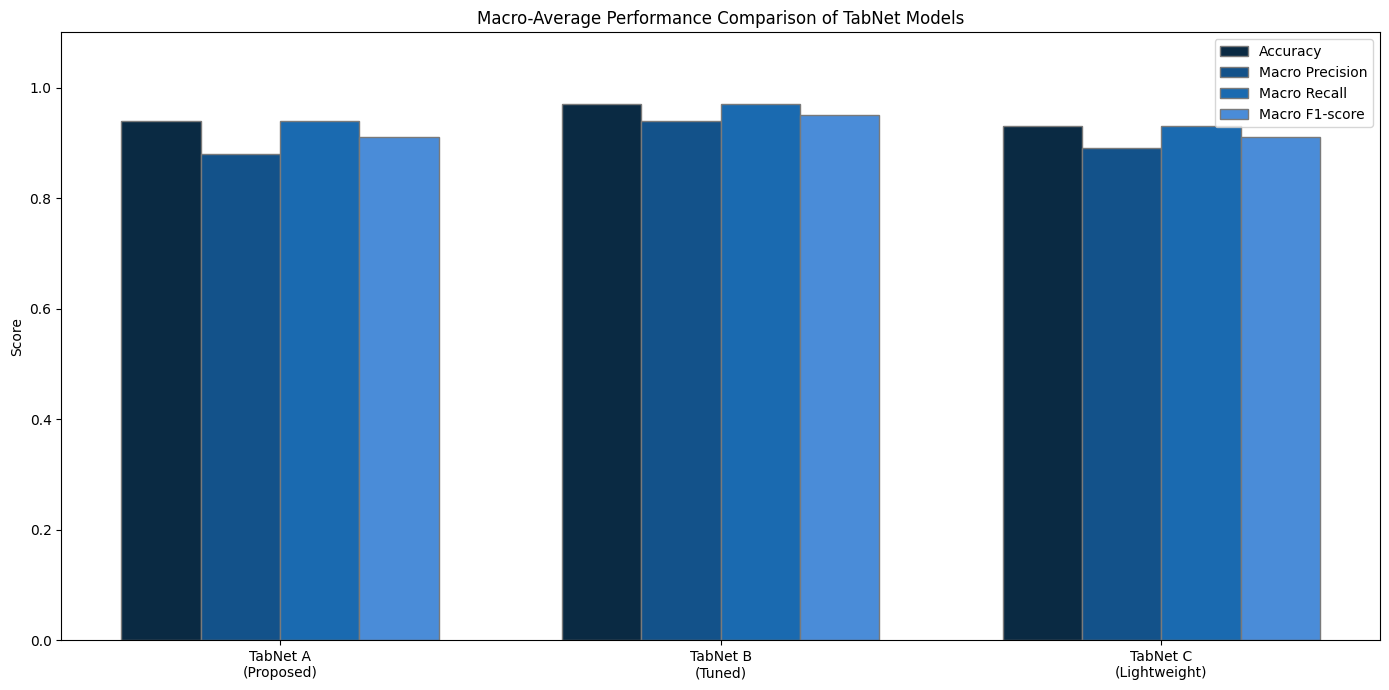

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for TabNet A, B, C
models = ["TabNet A\n(Proposed)", "TabNet B\n(Tuned)", "TabNet C\n(Lightweight)"]

macro_precision = [0.88, 0.94, 0.89]
macro_recall    = [0.94, 0.97, 0.93]
macro_f1        = [0.91, 0.95, 0.91]
accuracy        = [0.94, 0.97, 0.93]

x = np.arange(len(models))
width = 0.18

# Blue shades (dark → light)
blue_shades = ["#0a2a43", "#13528a", "#1a6ab0", "#4a8cd8"]
gray = "#7a7a7a"

plt.figure(figsize=(14, 7))

plt.bar(x - 1.5*width, accuracy,        width, label="Accuracy",     color=blue_shades[0], edgecolor=gray)
plt.bar(x - 0.5*width, macro_precision, width, label="Macro Precision", color=blue_shades[1], edgecolor=gray)
plt.bar(x + 0.5*width, macro_recall,    width, label="Macro Recall",    color=blue_shades[2], edgecolor=gray)
plt.bar(x + 1.5*width, macro_f1,        width, label="Macro F1-score",  color=blue_shades[3], edgecolor=gray)

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Macro-Average Performance Comparison of TabNet Models")

plt.legend()
plt.tight_layout()
plt.show()


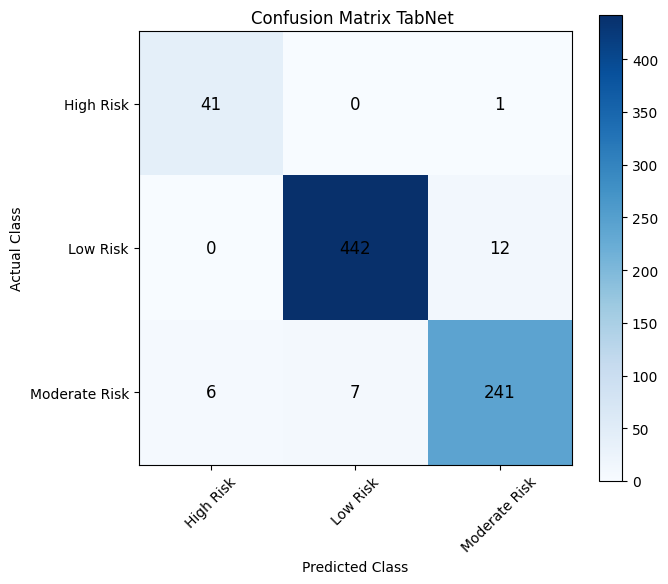

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = np.array([
    [41, 0, 1],
    [0, 442, 12],
    [6, 7, 241]
])

classes = ["High Risk", "Low Risk", "Moderate Risk"]

plt.figure(figsize=(7, 6))

# Use a BLUE gradient colormap
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title("Confusion Matrix TabNet ")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Label each cell with its number
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=12)

plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 10 high-risk students
test_high_risk = pd.DataFrame({
    "Attendance (%)": [50, 55, 52, 51, 53, 50, 54, 56, 52, 50],
    "Midterm_Score": [40, 45, 42, 41, 44, 43, 40, 45, 42, 41],
    "Assignments_Avg": [50, 52, 48, 49, 51, 47, 50, 52, 48, 49],
    "Quizzes_Avg": [50, 55, 53, 51, 52, 50, 54, 56, 52, 51],
    "Participation_Score": [5, 8, 4, 6, 7, 3, 5, 8, 4, 6],
    "Projects_Score": [50, 52, 49, 48, 51, 47, 50, 53, 49, 48]
})

import pandas as pd

# --- 1) أعمدة التدريب ---
X_custom = test_high_risk[
    ["Attendance (%)",
     "Participation_Score",
     "Quizzes_Avg",
     "Assignments_Avg",
     "Midterm_Score",
     "Projects_Score"]
]

# --- 2) numpy ---
X_custom = X_custom.to_numpy()

# --- 3) scaling ---
X_custom_scaled = scaler.transform(X_custom)

# --- توقعات TabNet ---
probs = tabnet12.predict_proba(X_custom_scaled)
preds = probs.argmax(axis=1)

print("Predictions:", preds)
print("\nProbabilities:\n", probs)



Predictions: [0 0 0 0 0 0 0 0 0 0]

Probabilities:
 [[9.9990511e-01 2.6306925e-12 9.4861512e-05]
 [9.9976069e-01 7.3496237e-11 2.3926170e-04]
 [9.9992263e-01 1.1485921e-12 7.7382916e-05]
 [9.9992430e-01 8.6170724e-13 7.5691598e-05]
 [9.9983275e-01 2.1330155e-11 1.6722135e-04]
 [9.9994361e-01 3.0967050e-13 5.6374796e-05]
 [9.9990511e-01 2.6306925e-12 9.4861512e-05]
 [9.9971360e-01 1.2643479e-10 2.8638134e-04]
 [9.9992263e-01 1.1485921e-12 7.7382916e-05]
 [9.9992430e-01 8.6170724e-13 7.5691598e-05]]


5-Fold Cross-Validation + Ensemble TabNet

In [ ]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# 1 Prepare Dataset


feature_cols = [
    'Attendance (%)',
    'Participation_Score',
    'Quizzes_Avg',
    'Assignments_Avg',
    'Midterm_Score',
    'Projects_Score'
]
target_col = "Risk_Level"

# Encode Risk Level → 0,1,2
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

# Save label encoder for deployment
joblib.dump(le, "label_encoder.pkl")

X = df[feature_cols].values
y = df[target_col].values



# 2. Train / Val / Test Split


# First split: Train + Val (80%), Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Second split: Train (70%), Val (30% of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.30,
    stratify=y_train_full,
    random_state=42
)

print("Train size:", len(X_train))
print("Val size  :", len(X_val))
print("Test size :", len(X_test))



# Scaling


# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform splits
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Save scaler for deployment (for predicting on new students)
joblib.dump(scaler, "scaler.pkl")



#  Class Weights (soft-balanced)

classes = np.unique(y_train)

raw_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

# soften extreme imbalance
soft_weights = raw_weights ** 0.8

class_weights = dict(zip(classes, soft_weights))

print("\nRaw class weights:", dict(zip(classes, raw_weights)))
print("Soft class weights:", class_weights)


Train size: 2800
Val size  : 1200
Test size : 1000

Raw class weights: {0: 5.982905982905983, 1: 0.5512896239417208, 2: 0.9814230634419909}
Soft class weights: {0: 4.183403376669639, 1: 0.6210175232143114, 2: 0.9851106352761524}


In [ ]:

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold = 1
tabnet_models = []

for train_idx, val_idx in skf.split(X_train_full, y_train_full):

    print(f"\n===== FOLD {fold} / {n_splits} =====")

    X_tr, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_tr, y_val = y_train_full[train_idx], y_train_full[val_idx]

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)

    # Save this fold's scaler
    joblib.dump(scaler, f"scaler_fold_{fold}.pkl")

    # TabNet Model
    tabnet_5fold = TabNetClassifier(
        n_d=16, n_a=16, n_steps=3,
        gamma=1.5,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingLR,
        scheduler_params={"T_max": 50, "eta_min": 1e-5},
        mask_type="sparsemax",
        seed=42
    )

    # Train
    tabnet_5fold.fit(
        X_tr_scaled, y_tr,
        eval_set=[(X_val_scaled, y_val)],
        eval_metric=['accuracy'],
        max_epochs=80,
        patience=20,
        batch_size=32,
        virtual_batch_size=16,
        weights=class_weights,        # Handles imbalance

        drop_last=False
    )

    # Save TabNet Model
    
    tabnet_5fold.save_model(f"tabnet_fold_{fold}")

    # Evaluate Fold
    y_val_pred = tabnet_5fold.predict(X_val_scaled)
    print("\nFold", fold, "Accuracy:", accuracy_score(y_val, y_val_pred))

    tabnet_models.append((tabnet_5fold, scaler))
    fold += 1


# 5. Test Final Ensemble
print("\n===== FINAL ENSEMBLE TEST =====")

all_probas = []

for model, scaler in tabnet_models:
    X_test_scaled_fold = scaler.transform(X_test)
    proba = model.predict_proba(X_test_scaled_fold)
    all_probas.append(proba)

mean_proba = np.mean(all_probas, axis=0)
y_pred = np.argmax(mean_proba, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(le.inverse_transform(y_test),
                            le.inverse_transform(y_pred)))



===== FOLD 1 / 5 =====
epoch 0  | loss: 1.08009 | val_0_accuracy: 0.63375 |  0:00:03s
epoch 1  | loss: 0.72846 | val_0_accuracy: 0.75    |  0:00:05s
epoch 2  | loss: 0.64702 | val_0_accuracy: 0.77625 |  0:00:08s
epoch 3  | loss: 0.58216 | val_0_accuracy: 0.8     |  0:00:11s
epoch 4  | loss: 0.54399 | val_0_accuracy: 0.81625 |  0:00:14s
epoch 5  | loss: 0.50753 | val_0_accuracy: 0.8475  |  0:00:17s
epoch 6  | loss: 0.49214 | val_0_accuracy: 0.85375 |  0:00:20s
epoch 7  | loss: 0.48076 | val_0_accuracy: 0.84875 |  0:00:23s
epoch 8  | loss: 0.49196 | val_0_accuracy: 0.8875  |  0:00:26s
epoch 9  | loss: 0.42813 | val_0_accuracy: 0.85875 |  0:00:29s
epoch 10 | loss: 0.43702 | val_0_accuracy: 0.86    |  0:00:33s
epoch 11 | loss: 0.40375 | val_0_accuracy: 0.87    |  0:00:37s
epoch 12 | loss: 0.43092 | val_0_accuracy: 0.88125 |  0:00:42s
epoch 13 | loss: 0.3933  | val_0_accuracy: 0.8725  |  0:00:45s
epoch 14 | loss: 0.3825  | val_0_accuracy: 0.87125 |  0:00:50s
epoch 15 | loss: 0.3923  | val_